<a href="https://colab.research.google.com/github/baussel/Satellite_Detection/blob/main/Image_Classifier_Test_V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# First Object Detection Model - Cats and Dogs

Test code to be copied for the real satellite detection model.

## Data Download

In [25]:
#Mount Google Drive with this Colab
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [26]:
#Download dataset of cats and dogs, 2000 images
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /content/cats_and_dogs_filtered.zip

--2021-07-20 11:02:45--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.73.208, 142.250.73.240, 142.250.65.80, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.73.208|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/content/cats_and_dogs_filtered.zip’

/content/cats_and_d 100%[===================>]  65.43M   106MB/s    in 0.6s    

2021-07-20 11:02:45 (106 MB/s) - ‘/content/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [27]:
#Save the data in the folder content
import os
import zipfile

local_zip = '/content/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content')
zip_ref.close()

## Data Preparation

In [4]:
#Installation of modules
!pip install wandb

     |████████████████████████████████| 1.8 MB 19.2 MB/s 
     |████████████████████████████████| 97 kB 8.6 MB/s 
     |████████████████████████████████| 133 kB 61.6 MB/s 
     |████████████████████████████████| 138 kB 68.6 MB/s 
     |████████████████████████████████| 170 kB 48.2 MB/s 
     |████████████████████████████████| 63 kB 2.2 MB/s 
     |████████████████████████████████| 62 kB 1.1 MB/s 
  Created wheel for subprocess32: filename=subprocess32-3.5.4-py3-none-any.whl size=6502 sha256=e189ffb72454e11222763e70e441225b381c25e1024bfdbab6100386408edcbb
  Stored in directory: /root/.cache/pip/wheels/50/ca/fa/8fca8d246e64f19488d07567547ddec8eb084e8c0d7a59226a
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8806 sha256=4572166fdc1015294e51f652364c7ea570673f10ab8d235c3d1baffafda987b8
  Stored in directory: /root/.cache/pip/wheels/3e/31/09/fa59cef12cdcfecc627b3d24273699f390e71828921b2cbba2
Successfully built subprocess32 pathtools
  Attempting uninstall: urll

In [28]:
#Import of the relevant modules
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import tensorflow_datasets as tfds

#Connection to Weight and Biases (https://wandb.ai)
import wandb
from wandb.keras import WandbCallback

In [29]:
#Paramters for the images
img_height = 256
img_width = 256

#Batch_size - Size of used images per step
batch_size = 20

#Image Path
image_path = '/content/cats_and_dogs_filtered'

In [30]:
#Definition of the training data
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    image_path+"/train",
    #validation_split = 0.2,
    #subset = "training",
    #seed = 123,
    image_size = (img_height, img_width),
    batch_size = batch_size,
    label_mode = "binary",
    color_mode = "rgb") #Maybe change to grayscale for satellites

Found 2000 files belonging to 2 classes.


In [96]:
#Definition of the validation data
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  image_path+"/validation",
  #validation_split= 0.2 ,
  #subset = "validation",
  #seed = 123,
  image_size = (img_height, img_width),
  batch_size = batch_size,
  label_mode = "binary",
  shuffle=False,
  color_mode = "rgb") #Maybe change to grayscale for satellites

Found 1000 files belonging to 2 classes.


In [32]:
#Return the class names
class_names = train_ds.class_names
print("Classes:",class_names)

Classes: ['cats', 'dogs']


In [33]:
print("Shape of the Dataset:")
print(train_ds)

Shape of the Dataset:
<BatchDataset shapes: ((None, 256, 256, 3), (None, 1)), types: (tf.float32, tf.float32)>


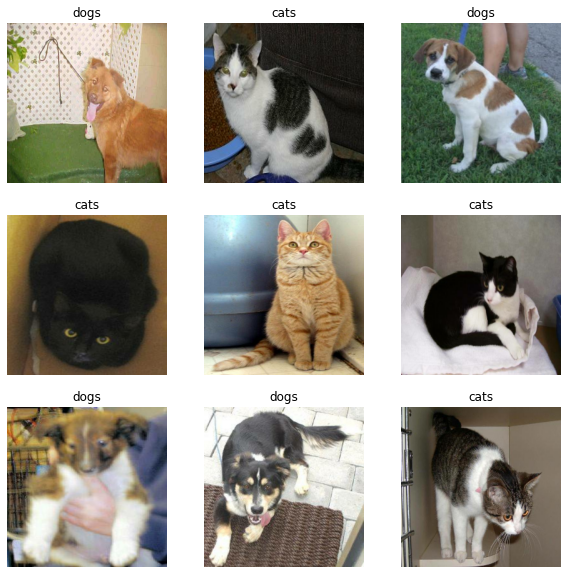

In [34]:
#Example Images
plt.figure(figsize=(10, 10))
for images,labels in train_ds.take(1): #Takes the first batch
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[int(labels[i])])
    plt.axis("off")

## Creating the model

Using the Inceptionv3 model

In [35]:
#Download weights
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2021-07-20 11:03:25--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.13.240, 172.217.15.80, 142.250.188.48, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.13.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M   113MB/s    in 0.7s    

2021-07-20 11:03:26 (113 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [40]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'
pre_trained_model = InceptionV3(
    input_shape=(img_height, img_width, 3), include_top=False, weights=None)
pre_trained_model.load_weights(local_weights_file)

#Not trainable
for layer in pre_trained_model.layers:
  layer.trainable = False

#Last Layer: Mixed7 - not used atm
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape:', last_layer.output_shape)
last_output = last_layer.output

last layer output shape: (None, 14, 14, 768)


In [12]:
#Learning rate
learn_rate = 0.0005

In [60]:
#Definition of the layers of the model
model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape = (img_height, img_width, 3)),
  pre_trained_model,
  layers.Flatten(),
  layers.Dense(128, activation = 'relu'),
  #Dropout
  layers.Dropout(0.5),
  #Output
  layers.Dense(1, activation = 'sigmoid')
])

In [61]:
#Compiling of the model, loss function is binary
model.compile(optimizer = 'adam', #Adam automatically uses the best learning rate
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])

In [62]:
#Overview over the model
model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 256, 256, 3)       0         
_________________________________________________________________
inception_v3 (Functional)    (None, 6, 6, 2048)        21802784  
_________________________________________________________________
flatten_12 (Flatten)         (None, 73728)             0         
_________________________________________________________________
dense_22 (Dense)             (None, 128)               9437312   
_________________________________________________________________
dropout_12 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_23 (Dense)             (None, 1)                 129       
Total params: 31,240,225
Trainable params: 9,437,441
Non-trainable params: 21,802,784
_________________________________

## Training of the model

In [63]:
#Connection to Weights and Biases
#parameters
config = wandb.config
config.learning_rate = learn_rate
wandb.init(project = 'image_classifier_inception')

#Number of epochs for the training
epoch_number = 50

#Starting the training and storing the result in 'history'
history = model.fit(
  train_ds,
  validation_data = val_ds,
  epochs = epoch_number,
  callbacks = [WandbCallback()])

epoch,2
loss,0.69283
accuracy,0.489
val_loss,0.69315
val_accuracy,0.5
_runtime,63
_timestamp,1626779636
_step,2
best_val_loss,0.69315
best_epoch,1


epoch,▁▅█
loss,█▁▁
accuracy,█▅▁
val_loss,█▁█
val_accuracy,▁▁▁
_runtime,▁▄█
_timestamp,▁▄█
_step,▁▅█


Epoch 1/50
100/100 [==============================] - 18s 143ms/step - loss: 1.6368 - accuracy: 0.9485 - val_loss: 0.2313 - val_accuracy: 0.9770
Epoch 2/50
100/100 [==============================] - 13s 129ms/step - loss: 0.1052 - accuracy: 0.9850 - val_loss: 0.0326 - val_accuracy: 0.9910
Epoch 3/50
100/100 [==============================] - 13s 132ms/step - loss: 0.0393 - accuracy: 0.9915 - val_loss: 0.0554 - val_accuracy: 0.9830
Epoch 4/50
100/100 [==============================] - 13s 132ms/step - loss: 0.0166 - accuracy: 0.9950 - val_loss: 0.0669 - val_accuracy: 0.9860
Epoch 5/50
100/100 [==============================] - 13s 131ms/step - loss: 0.0085 - accuracy: 0.9950 - val_loss: 0.0803 - val_accuracy: 0.9900
Epoch 6/50
100/100 [==============================] - 13s 131ms/step - loss: 0.0657 - accuracy: 0.9880 - val_loss: 0.1042 - val_accuracy: 0.9890
Epoch 7/50
100/100 [==============================] - 13s 132ms/step - loss: 0.0656 - accuracy: 0.9865 - val_loss: 0.0660 - val_ac

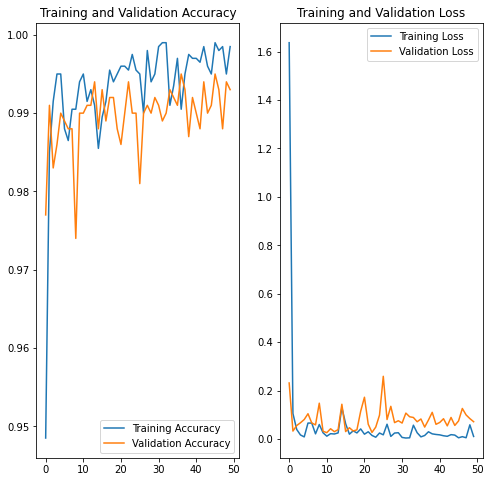

In [64]:
#Plot the training progress

#Accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

#Loss
loss = history.history['loss']
val_loss = history.history['val_loss']

#Epochs
epochs_range = range(epoch_number)

#Plot - Accuracy
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label = 'Training Accuracy')
plt.plot(epochs_range, val_acc, label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')

#Plot - Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label = 'Training Loss')
plt.plot(epochs_range, val_loss, label = 'Validation Loss')
plt.legend(loc = 'upper right')
plt.title('Training and Validation Loss')
plt.show()

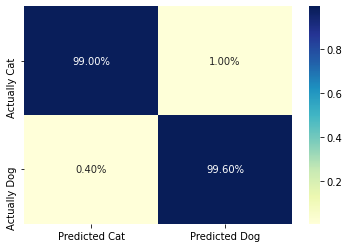

In [171]:
#Pandas Flatten module
from pandas.core.common import flatten

#Extract labels and predictions for validation data of the model
y_pred_list = []
y_real_list = []
for images, labels in val_ds:
  #Prediction
  class_pr = (model.predict(images) > 0.5).astype("int32")
  y_pred_list.append(class_pr)
  #Label
  lab = list(np.ndarray.flatten(labels.numpy()))
  y_real_list.append(lab)
y_real = list(flatten(y_real_list))
y_pred = list(flatten(y_pred_list))

#Confusion matrix module
from sklearn.metrics import confusion_matrix
#Modules for displaying the matrix
import seaborn as sns
import pandas as pd

#Calculates the values of the matrix
confusion_matrix_scores = confusion_matrix(y_real, y_pred, labels=[1, 0], normalize = "true")

#Draw and show the matrix
df = pd.DataFrame(confusion_matrix_scores, 
                  columns = ["Predicted Cat", "Predicted Dog"],
                  index = ["Actually Cat", "Actually Dog"])
sns.heatmap(df, annot=True, fmt=".2%", cmap="YlGnBu")
plt.show()

In [173]:
#Extract true/false positive/negative values
tp, fn, fp, tn = confusion_matrix_scores.ravel()

#Calculate precision and recall
precision = tp / (tp + fp)
recall =  tp / (tp + fn)
print("Precision:", precision)
print("Recall:", recall)

Precision: 0.9959758551307847
Recall: 0.99


## Prediction of unknown images

In [71]:
#Load image
img = keras.preprocessing.image.load_img(
    image_path+"/validation/dogs/dog.2018.jpg", 
    target_size = (img_height, img_width))

#Process the image to an array and then to a batch
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

#Calculate the (binary) prediction
class_pr = (model.predict(img_array) > 0.5).astype("int32") #For binary prediction
score_pr = model.predict(img_array)
if class_pr == 0:
  score_pr = 1 - score_pr

#Print the result
print("This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[int(class_pr)], 100 *float(score_pr)))

This image most likely belongs to dogs with a 99.98 percent confidence.
